# Basic Imports

In [0]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
from PIL import Image
from torch import optim
import matplotlib.pyplot as plt
import math
import torchvision.utils as vutils

%matplotlib inline

%load_ext tensorboard
import os, shutil
import time, datetime

def delete_logs():
  folder = "./logs"
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

delete_logs()
def get_tensorboard_logger():
  logs_base_dir = "./logs"
  logs_dir = logs_base_dir + "/run_" + str(time.mktime(datetime.datetime.now().timetuple()))
  os.makedirs(logs_dir, exist_ok=True)
  from torch.utils.tensorboard import SummaryWriter
  %tensorboard --logdir {logs_base_dir} --port=8998
  logger = SummaryWriter(logs_dir)
  return logger

# MNIST Dataset

In [0]:
# from torchvision.datasets import MNIST
# from torchvision import datasets
# from torchvision import transforms

# batch_size = 50
# train_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data', train=True, download=True,
#                        transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
#                        ])),
#         batch_size=batch_size, shuffle=True )

# test_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
#                        ])),
#         batch_size=batch_size, shuffle=True)

# Cluttered MNIST
https://github.com/kvn219/cluttered-mnist/blob/master/spatial-transformer-network/Clutter_MNIST_Example.ipynb

In [0]:
class CTrainDataset():
  def __init__(self, input_path):    
    mnist_cluttered = np.load(input_path)
    self.X_train = mnist_cluttered['X_train']
    self.y_train = mnist_cluttered['y_train']
    self.length = len(self.X_train)
  
  def __len__(self):
    return self.length 
  
  def __getitem__(self, index):
    return self.X_train[index].reshape((1, 40, 40)), self.y_train[index][0]

def custom_collate(batch):
  return default_collate(batch)

class CTestDataset():
  def __init__(self, input_path):    
    mnist_cluttered = np.load(input_path)
    self.X_test = mnist_cluttered['X_test']
    self.y_test = mnist_cluttered['y_test']
    self.length = len(self.X_test)
  
  def __len__(self):
    return self.length 
  
  def __getitem__(self, index):
    return self.X_test[index].reshape((1, 40, 40)), self.y_test[index][0]

def custom_collate(batch):
  return default_collate(batch)

0.99609375
8


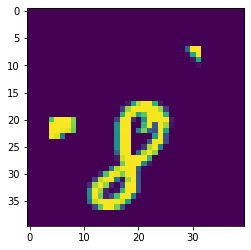

In [4]:
batch_size = 1000
train_dataset = CTrainDataset('mnist_sequence1_sample_5distortions5x5.npz')
test_dataset = CTestDataset('mnist_sequence1_sample_5distortions5x5.npz')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False )

idx = 6
img, y = train_dataset[idx]
img = img[0]
print(np.max(img))
print(y)
plt.imshow(img)
plt.show()

# Model

In [0]:
def get_norm(norm_type, num_features, num_groups=32, eps=1e-5):
  if norm_type == 'BatchNorm':
    return nn.BatchNorm2d(num_features, eps=eps)
  elif norm_type == "GroupNorm":
    return nn.GroupNorm(num_groups, num_features, eps=eps)
  elif norm_type == "InstanceNorm":
    return nn.InstanceNorm2d(num_features, eps=eps, affine=True, track_running_stats=True)
  else:
    raise Exception('Unknown Norm Function : {}'.format(norm_type))


In [0]:
import torch
from torch import nn
from torch.nn import functional as F

class Conv2dNormRelu(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=0, bias=True, norm_type='Unknown'):
    super(Conv2dNormRelu, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=bias),
        get_norm(norm_type, out_ch),
        nn.ReLU(inplace=True))
  def forward(self, x):
    return self.conv(x)


class CAModule(nn.Module):
  def __init__(self, num_channels, reduc_ratio=2):
    super(CAModule, self).__init__()
    self.num_channels = num_channels
    self.reduc_ratio = reduc_ratio
    self.fc1 = nn.Linear(num_channels, num_channels // reduc_ratio, bias=True)
    self.fc2 = nn.Linear(num_channels // reduc_ratio, num_channels, bias=True)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
  def forward(self, feat_map):
    gap_out = feat_map.view(feat_map.size()[0], self.num_channels, -1).mean(dim=2)
    fc1_out = self.relu(self.fc1(gap_out))
    fc2_out = self.sigmoid(self.fc2(fc1_out))
    fc2_out = fc2_out.view(fc2_out.size()[0], fc2_out.size()[1], 1, 1)
    feat_map = torch.mul(feat_map, fc2_out)
    return feat_map, [fc2_out]

class SAModule(nn.Module):
  def __init__(self, num_channels):
    super(SAModule, self).__init__()
    self.num_channels = num_channels
    self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_channels // 8, kernel_size=1)
    self.conv2 = nn.Conv2d(in_channels=num_channels, out_channels=num_channels // 8, kernel_size=1)
    self.conv3 = nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=1)
    self.gamma = nn.Parameter(torch.zeros(1))
  
  def forward(self, feat_map):
    batch_size, num_channels, height, width = feat_map.size()
    conv1_proj = self.conv1(feat_map).view(batch_size, -1, width * height).permute(0, 2, 1)
    conv2_proj = self.conv2(feat_map).view(batch_size, -1, width * height)
    relation_map = torch.bmm(conv1_proj, conv2_proj)
    attention = F.softmax(relation_map, dim=-1)
    conv3_proj = self.conv3(feat_map).view(batch_size, -1, width * height)
    feat_refine = torch.bmm(conv3_proj, attention.permute(0, 2, 1))
    feat_refine = feat_refine.view(batch_size, num_channels, height, width)
    feat_map = self.gamma * feat_refine + feat_map
    return feat_map, [self.gamma * feat_refine, feat_refine]


class FPAModule(nn.Module):
  def __init__(self, num_channels, norm_type):
    super(FPAModule, self).__init__()
    self.gap_branch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Conv2dNormRelu(num_channels, num_channels, kernel_size=1, norm_type=norm_type))
    self.mid_branch = Conv2dNormRelu(num_channels, num_channels, kernel_size=1, norm_type=norm_type)
    self.downsample1 = Conv2dNormRelu(num_channels, 1, kernel_size=3, stride=2, padding=1, norm_type=norm_type)
    self.downsample2 = Conv2dNormRelu(1, 1, kernel_size=3, stride=2, padding=1, norm_type=norm_type)
    # self.downsample3 = Conv2dNormRelu(1, 1, kernel_size=3, stride=2, padding=1, norm_type=norm_type)
    self.scale1 = Conv2dNormRelu(1, 1, kernel_size=3, padding=1, norm_type=norm_type)
    self.scale2 = Conv2dNormRelu(1, 1, kernel_size=3, padding=1, norm_type=norm_type)
    # self.scale3 = Conv2dNormRelu(1, 1, kernel_size=3, padding=1, norm_type=norm_type)
  
  def forward(self, feat_map):
    height, width = feat_map.size(2), feat_map.size(3)
    gap_branch = self.gap_branch(feat_map)
    gap_branch = nn.Upsample(size=(height, width), mode='bilinear', align_corners=False)(gap_branch)
    mid_branch = self.mid_branch(feat_map)
    scale1 = self.downsample1(feat_map)
    scale2 = self.downsample2(scale1)
    # scale3 = self.downsample3(scale2)
    # scale3 = self.scale3(scale3)
    # scale3 = nn.Upsample(size=(int(math.ceil(height*1.0 / 4.0)), int(math.ceil(width*1.0 / 4.0))), mode='bilinear', align_corners=False)(scale3)
    # scale2 = self.scale2(scale2) + scale3
    scale2 = self.scale2(scale2)
    scale2 = nn.Upsample(size=(int(math.ceil(height*1.0 / 2.0)), int(math.ceil(width*1.0 / 2.0))), mode='bilinear', align_corners=False)(scale2)
    scale1 = self.scale1(scale1) + scale2
    scale1 = nn.Upsample(size=(height, width), mode='bilinear', align_corners=False)(scale1)
    feat_map = torch.mul(scale1, mid_branch) + gap_branch
    return feat_map, []


In [7]:
from torchvision.models.utils import load_state_dict_from_url
from torchvision.models.resnet import BasicBlock, _resnet
import torch.nn as nn 

global_batchid = -1
global_epoch = -1
global_id = 0
global_logger = get_tensorboard_logger()

class AdvancedBasicBlock(BasicBlock):
  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
    super(AdvancedBasicBlock, self).__init__(inplanes, planes, stride=stride, downsample=downsample, groups=groups,
                 base_width=base_width, dilation=dilation, norm_layer=norm_layer)
    
    print(self.bn2.num_features)
    global global_id
    self.id = global_id
    global_id += 1
    self.attention_layer = None
  
  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    
    out = self.conv2(out)
    out = self.bn2(out)
    out, plot_data = self.attention_layer(out)
    
    global global_batchid, global_epoch, global_logger

    local_batch_id = global_batchid
    local_epoch = global_epoch

    if  not self.training and local_batch_id < 1:
      for index, value in enumerate(plot_data):
        for channel_id in range(value.shape[1]):
          key = str(self.id) + "_" + str(local_batch_id) + "_" + str(channel_id)
          sample = value[:, channel_id, :, :].unsqueeze(1)
          # sample = sample.repeat(1, 3, 1, 1)
          global_logger.add_images(key, vutils.make_grid(sample.cpu(), padding=2).unsqueeze(0),  local_epoch)
          
    
    if self.downsample is not None:
      identity = self.downsample(x)
    
    out += identity
    out = self.relu(out)
    return out

class AdvancedBasicBlock_CAM(AdvancedBasicBlock):
  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, 
               base_width=64, dilation=1, norm_layer=None):
    super(AdvancedBasicBlock_CAM, self).__init__(inplanes, planes, stride=stride, downsample=downsample, groups=groups,
                 base_width=base_width, dilation=dilation, norm_layer=norm_layer)
    self.attention_layer = CAModule(self.bn2.num_features)

class AdvancedBasicBlock_SAM(AdvancedBasicBlock):
  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, 
               base_width=64, dilation=1, norm_layer=None):
    super(AdvancedBasicBlock_SAM, self).__init__(inplanes, planes, stride=stride, downsample=downsample, groups=groups,
                 base_width=base_width, dilation=dilation, norm_layer=norm_layer)
    self.attention_layer = SAModule(self.bn2.num_features)

class AdvancedBasicBlock_FPA(AdvancedBasicBlock):
  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, 
               base_width=64, dilation=1, norm_layer=None):
    super(AdvancedBasicBlock_FPA, self).__init__(inplanes, planes, stride=stride, downsample=downsample, groups=groups,
                 base_width=base_width, dilation=dilation, norm_layer=norm_layer)
    self.attention_layer = FPAModule(self.bn2.num_features, 'BatchNorm')

    
def newResnet34(blk, pretrained=False, progress=True, **kwargs):
  return _resnet('resnet34', blk, [3, 4, 6, 3], pretrained, progress, **kwargs)


Reusing TensorBoard on port 8998 (pid 3460), started 0:14:35 ago. (Use '!kill 3460' to kill it.)

# Network

In [0]:
class Network():
  def __init__(self, bs=50, lr=0.001, epochs=10, model=None, mode='default'):
    self.lr = lr
    self.epochs = epochs
    self.batch_size = bs
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.kwargs = {'num_workers': 0, 'pin_memory': True} 
    if model is not None:
      self.model = model.to(self.device)
    else:
      if mode == 'default':
        resnet = torchvision.models.resnet34(pretrained=True)
      elif mode == 'sam':
        resnet = newResnet34(AdvancedBasicBlock_SAM, pretrained=False)
        k = load_state_dict_from_url('https://download.pytorch.org/models/resnet34-333f7ec4.pth')
        resnet.load_state_dict(k, strict=False)
      elif mode == 'cam':
        resnet = newResnet34(AdvancedBasicBlock_CAM, pretrained=False)
        k = load_state_dict_from_url('https://download.pytorch.org/models/resnet34-333f7ec4.pth')
        resnet.load_state_dict(k, strict=False)
      elif mode == 'fpa':
        resnet = newResnet34(AdvancedBasicBlock_FPA, pretrained=False)
        k = load_state_dict_from_url('https://download.pytorch.org/models/resnet34-333f7ec4.pth')
        resnet.load_state_dict(k, strict=False)

      resnet.conv1 = nn.Conv2d(1, 64, 7, stride=2, padding=3, bias=False)
      resnet.fc = nn.Linear(512, 10)
      self.model = resnet.to(self.device)
      model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
      params = sum([np.prod(p.size()) for p in model_parameters])
      print("Number of Parameters: ", params)
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    self.criterion = nn.CrossEntropyLoss()
    global global_logger
    self.logger = global_logger

  def train(self, train_loader, test_loader):
    self.model.train()
    for epoch in range(self.epochs):
      self.model.train()
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(self.device), target.to(self.device).long()
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = self.criterion(output, target)
          loss.backward()
          self.optimizer.step()
          self.logger.add_scalar('Train_Loss', loss.item(), epoch*len(train_loader) + batch_idx)
          if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
      self.test(epoch, test_loader)  

  def test(self, epoch, test_loader):
    self.model.eval()
    test_loss = 0
    correct = 0
    global global_epoch, global_batchid
    global_epoch = epoch 
    with torch.no_grad():
        for batch_id, tup in enumerate(test_loader):
            global_batchid = batch_id
            data, target = tup
            data, target = data.to(self.device), target.to(self.device).long()
            # plt.imshow(data[0].transpose(0,1).transpose(1,2).squeeze())
            # plt.show()
            output = self.model(data)
            test_loss += self.criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            if(batch_id == 0):
              global_logger.add_images("Input Image", vutils.make_grid(data.cpu(), padding=2).unsqueeze(0),  epoch)
    test_loss /= len(test_loader)
    self.logger.add_scalar('Test_Loss', test_loss, epoch)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


# Build Model

In [0]:
resnet = Network(bs=batch_size, epochs=50, lr=0.001, mode='sam')
resnet.train(train_loader=train_loader, test_loader=test_loader)

# print(resnet.model)
# from torchsummary import summary
# summary(resnet.model, input_size=(1, 40, 40))

64
64
64
128
128
128
128
256
256
256
256
256
256
512
512
512
Number of Parameters:  22860106
Train Epoch: 0 [0/10000 (0%)]	Loss: 2.670158

Test set: Average loss: 7.3223, Accuracy: 224/1000 (2240%)

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.677372

Test set: Average loss: 9.2118, Accuracy: 204/1000 (2040%)

Train Epoch: 2 [0/10000 (0%)]	Loss: 0.311813

Test set: Average loss: 6.9171, Accuracy: 250/1000 (2500%)

Train Epoch: 3 [0/10000 (0%)]	Loss: 0.191767

Test set: Average loss: 5.3091, Accuracy: 303/1000 (3030%)

Train Epoch: 4 [0/10000 (0%)]	Loss: 0.116164

Test set: Average loss: 0.9152, Accuracy: 789/1000 (7890%)

Train Epoch: 5 [0/10000 (0%)]	Loss: 0.083475

Test set: Average loss: 0.5644, Accuracy: 870/1000 (8700%)

Train Epoch: 6 [0/10000 (0%)]	Loss: 0.056215

Test set: Average loss: 0.8212, Accuracy: 815/1000 (8150%)

Train Epoch: 7 [0/10000 (0%)]	Loss: 0.066211

Test set: Average loss: 0.6334, Accuracy: 860/1000 (8600%)

Train Epoch: 8 [0/10000 (0%)]	Loss: 0.074346

Test set: Ave

# Train